## Chapter 8 - Time Series Anomaly Explainability

This notebook is a reference for SHAP for time series anomaly detection using OmniXAI.

Author: Cher Simon

In [ ]:
import sys
!{sys.executable} -m pip install -qU omnixai tensorflow

In [1]:
# Load essential libraries

%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2022-10-31 21:11:03.015784: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load a modified global land and ocean temperature anomaly dataset. Original dataset available at https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies/anomalies
# A positive value means that the observed temperature was warmer than the reference value
# A negative value means that the observed temperature was cooler than the reference value

data = pd.read_csv("./data/climate_anomalies.csv")
data['year'] = data['year'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
data.head(5)

,year,value
0,1880-01-01,-0.06
1,1880-02-01,-0.14
2,1880-03-01,-0.09
3,1880-04-01,-0.04
4,1880-05-01,-0.09


In [3]:
# Standardize the data

scaler = StandardScaler()
scaler.fit(data[["value"]])

data["scaled_temp"] = scaler.transform(data[["value"]])
data.head(5)

,year,value,scaled_temp
0,1880-01-01,-0.06,-0.384907
1,1880-02-01,-0.14,-0.601165
2,1880-03-01,-0.09,-0.466004
3,1880-04-01,-0.04,-0.330842
4,1880-05-01,-0.09,-0.466004


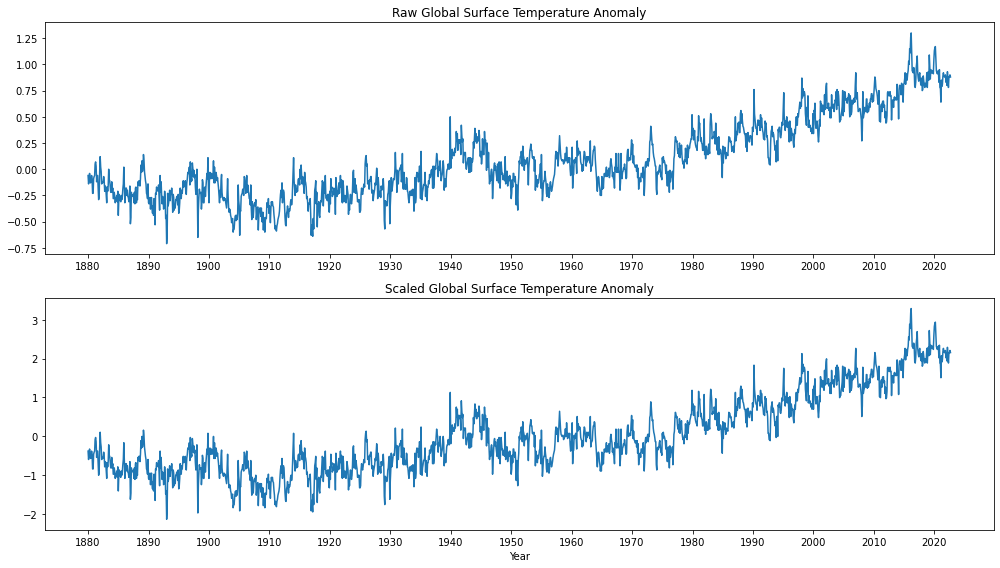

In [9]:
# Visualize the trend between 1880 and 2022

fig, axs = plt.subplots(2,sharex=False, sharey=False, figsize=(14,8))

years = mdates.YearLocator(10) 
yearsFmt = mdates.DateFormatter('%Y')

x_year = data['year']
y_total = data['value']
y_scaled = data['scaled_temp']

axs[0].plot(x_year,y_total)
axs[0].set_title("Raw Global Surface Temperature Anomaly")
axs[0].xaxis.set_major_locator(years)
axs[0].xaxis.set_major_formatter(yearsFmt)
axs[1].plot(x_year,y_scaled)
axs[1].set_title("Scaled Global Surface Temperature Anomaly")
axs[1].xaxis.set_major_locator(years)
axs[1].xaxis.set_major_formatter(yearsFmt)
plt.xlabel('Year')

fig.tight_layout()

In [10]:
# Use 80% for training and last 12 months trend

TIMESTEPS = 12            

train_data, test_data = train_test_split(data, train_size=0.8, shuffle=False, random_state=42)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)
train_data.shape, test_data.shape

((1370, 3), (343, 3))

In [11]:
# Prepare a new training dataset

def newdataset(df, timesteps, feature):
    df_x, df_y = [], []

    for i in range(timesteps, len(df)):
        df_x.append(df.iloc[i-timesteps:i][[feature]].values)
        df_y.append(df.iloc[i][feature])
    df_x = np.array(df_x)
    df_y = np.array(df_y)
    return df_x, df_y

train_x, train_y = newdataset(train_data, TIMESTEPS, 'scaled_temp')
test_x, test_y = newdataset(test_data, TIMESTEPS, 'scaled_temp')

In [12]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1358, 12, 1), (1358,), (331, 12, 1), (331,))

In [13]:
# Build a model

LSTM_units = 64
model = keras.Sequential()
model.add(LSTM(LSTM_units, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False,name='encoder_lstm'
              ))
model.add(Dropout(0.2, name='encoder_dropout'))
model.add(RepeatVector(train_x.shape[1], name='decoder_repeater'))
model.add(LSTM(LSTM_units, return_sequences=True, name='decoder_lstm'))
model.add(Dropout(rate=0.2, name='decoder_dropout'))
model.add(TimeDistributed(Dense(train_x.shape[2],name='decoder_dense_output')))

model.compile(loss='mae', optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_lstm (LSTM)         (None, 64)                16896     
                                                                 
 encoder_dropout (Dropout)   (None, 64)                0         
                                                                 
 decoder_repeater (RepeatVec  (None, 12, 64)           0         
 tor)                                                            
                                                                 
 decoder_lstm (LSTM)         (None, 12, 64)            33024     
                                                                 
 decoder_dropout (Dropout)   (None, 12, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 12, 1)            65        
 ibuted)                                                

In [15]:
# Train a model

%time 

history = model.fit(
    train_x, 
    train_x, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1, 
    shuffle=False
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/20
39/39 [==============================] - 4s 18ms/step - loss: 0.3133 - val_loss: 0.2534
Epoch 2/20
39/39 [==============================] - 0s 5ms/step - loss: 0.2330 - val_loss: 0.2214
Epoch 3/20
39/39 [==============================] - 0s 5ms/step - loss: 0.2187 - val_loss: 0.2116
Epoch 4/20
39/39 [==============================] - 0s 5ms/step - loss: 0.2083 - val_loss: 0.2173
Epoch 5/20
39/39 [==============================] - 0s 5ms/step - loss: 0.2062 - val_loss: 0.2152
Epoch 6/20
39/39 [==============================] - 0s 5ms/step - loss: 0.1989 - val_loss: 0.2068
Epoch 7/20
39/39 [==============================] - 0s 5ms/step - loss: 0.1956 - val_loss: 0.2057
Epoch 8/20
39/39 [==============================] - 0s 5ms/step - loss: 0.1980 - val_loss: 0.2416
Epoch 9/20
39/39 [==============================] - 0s 5ms/step - loss: 0.1933 - val_loss: 0.2126
Epoch 10/20
39/39 [==============================] - 

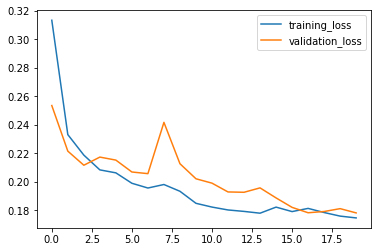

In [16]:
# Evaluate a model

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()


In [17]:
# Detect anomalies

reconstructed = model.predict(train_x)
reconstructed.shape, train_x.shape

43/43 [==============================] - 1s 2ms/step


((1358, 12, 1), (1358, 12, 1))

In [18]:
# Evaluate reconstruction

mae_loss = np.mean(np.abs(reconstructed - train_x), axis=1)
mae_loss.shape

(1358, 1)

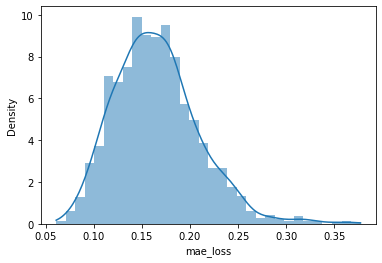

In [19]:
sns.histplot(mae_loss[:,0], kde=True, stat="density", linewidth=0).set_xlabel("mae_loss")
plt.show()

In [20]:
# Set a threshold
THRESHOLD = 0.90

In [21]:
test_reconstruction = model.predict(test_x)
test_reconstruction.shape

11/11 [==============================] - 0s 2ms/step


(331, 12, 1)

In [22]:
# MAE for test data reconstruction

test_mae_loss = np.mean(np.abs(test_x - test_reconstruction), axis=1)
test_mae_loss.shape

(331, 1)

In [23]:
# Setting index based on past N timesteps in test_df

anomaly_results_df = test_data[TIMESTEPS:][['value', 'scaled_temp']].copy()
anomaly_results_df.index = test_data[TIMESTEPS:].index

anomaly_results_df['year'] = data["year"]
anomaly_results_df['deviation'] = test_mae_loss
anomaly_results_df['threshold'] = THRESHOLD
anomaly_results_df['anomaly'] = anomaly_results_df['deviation'].apply(lambda dev: 1 if dev > THRESHOLD else 0)

anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 1]
not_anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 0]
anomalies.shape, not_anomalies.shape

((26, 6), (305, 6))

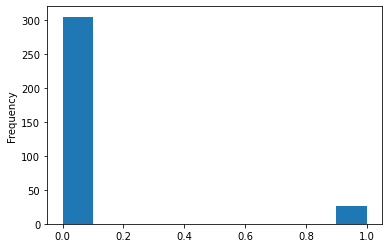

In [24]:
anomaly_results_df['anomaly'].plot(kind='hist')
plt.show()

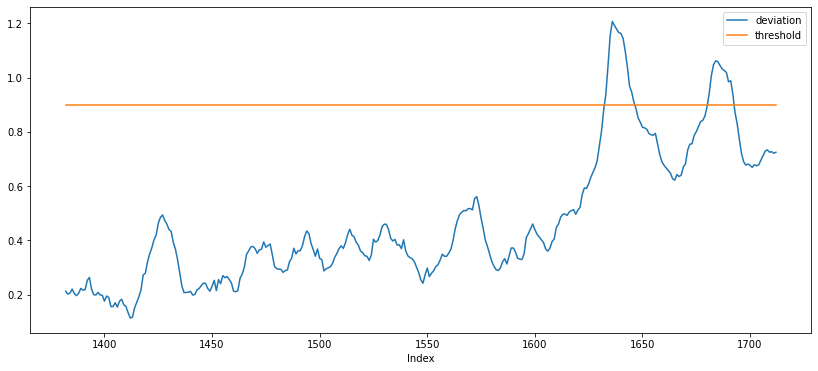

In [25]:
anomaly_results_df[['deviation', 'threshold']].plot(figsize=(14, 6))
plt.xlabel('Index')
plt.show()

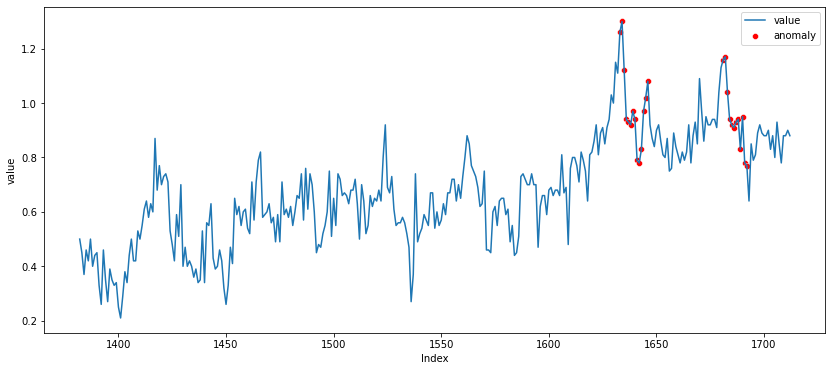

In [26]:
anomaly_results_df[['value']].plot(figsize=(14, 6))
sns.scatterplot(x=anomalies.index, y=anomalies['value'],label='anomaly',color='r')
plt.xlabel('Index')
plt.show()

In [28]:
anomalies

,value,scaled_temp,year,deviation,threshold,anomaly
1633,1.26,3.183359,2016-02-01,0.939949,0.9,1
1634,1.30,3.291488,2016-03-01,1.044035,0.9,1
1635,1.12,2.804907,2016-04-01,1.154755,0.9,1
1636,0.94,2.318325,2016-05-01,1.206609,0.9,1
1637,0.93,2.291293,2016-06-01,1.191849,0.9,1
1638,0.92,2.264260,2016-07-01,1.178030,0.9,1
1639,0.97,2.399422,2016-08-01,1.165603,0.9,1
1640,0.94,2.318325,2016-09-01,1.162151,0.9,1
1641,0.79,1.912840,2016-10-01,1.144242,0.9,1
1642,0.78,1.885808,2016-11-01,1.096602,0.9,1


## Local explanations

In [30]:
# Load the essential library

from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer
from omnixai.explainers.timeseries import ShapTimeseries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
# Load the time series dataset
df = pd.read_csv("./data/climate_anomalies.csv")
df['year_month'] = df['year'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df = df.drop('year', axis=1)
df = df.set_index("year_month")

In [32]:
# Split the dataset into training and test dataset
train_df = df.iloc[:1500]
test_df = df.iloc[1500:1713]

# Set a threshold for detecting anomaly data points
threshold = np.percentile(train_df["value"].values, 90)

In [33]:
# Determine whether a window of time series is anomalous
def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > threshold).astype(int))
    return anomaly_scores / ts.shape[0]

In [52]:
# Initialize a TimeseriesExplainer
explainers = TimeseriesExplainer(
    explainers=["shap"],
    mode="anomaly_detection",
    data=Timeseries.from_pd(train_df),
    model=detector,
    preprocess=None,
    postprocess=None
)

# Generate explanations
test_instances = Timeseries.from_pd(test_df)
local_explanations = explainers.explain(
    test_instances,
    params={"shap": {"nsamples": 213}}
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
# Generate visualization
index=0
print("SHAP results:")
local_explanations["shap"].ipython_plot(index)

SHAP results:
